In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [245]:
import warnings
warnings.filterwarnings('ignore')

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [562]:
data = pd.read_csv('Kobe.csv')

In [563]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [224]:
target = 'shot_made_flag'

In [564]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

# **Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [226]:
data['shot_made_flag'].unique()

array([nan,  0.,  1.])

In [227]:
data.dropna(subset=['shot_made_flag'],inplace = True)

In [228]:
# Добавляем несколько временных столбцов к данным
data['game_date_DT'] = pd.to_datetime(data['game_date'])

data['dayOfWeek'] = data['game_date_DT'].dt.dayofweek
data['dayOfYear'] = data['game_date_DT'].dt.dayofyear
data['month'] = data['game_date_DT'].dt.month
data['year'] = data['game_date_DT'].dt.year
data['quarter'] = data['game_date_DT'].dt.quarter

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int) * (data['period'] - 1) * 12 * 60 + (data['period'] > 4).astype(int) * ((data['period'] - 4) * 5 * 60 + 3 * 12 * 60) + data['secondsFromPeriodStart']

In [229]:
#удалим ненужные параметры
data.drop(['game_event_id',
        'game_id',
        'season',
        'team_id',
        'team_name',
        'matchup',
        'shot_id',
        'game_date',
        'minutes_remaining',
        'seconds_remaining',
        'game_date_DT',
        'action_type',
        'opponent'], axis = 1, inplace = True)

In [230]:
#числовые переменные
columns_non_objects = list(data.select_dtypes(exclude = object).columns)
for i in ['playoffs','shot_made_flag']:
    columns_non_objects.remove(i)
columns_non_objects

['lat',
 'loc_x',
 'loc_y',
 'lon',
 'period',
 'shot_distance',
 'dayOfWeek',
 'dayOfYear',
 'month',
 'year',
 'quarter',
 'secondsFromPeriodEnd',
 'secondsFromPeriodStart',
 'secondsFromGameStart']

<AxesSubplot:xlabel='period'>

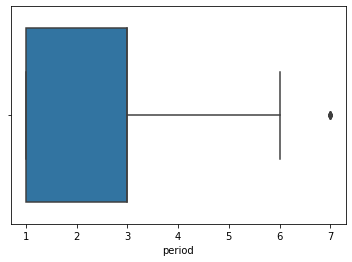

In [231]:
sns.boxplot(x=data['period'])

In [232]:
#удалим выброс
data = data[data['period'] != 7]

In [233]:
#применим OneHotEncoder к категориальным переменным

data1 = data.select_dtypes(exclude = object)
data2 = pd.get_dummies(data.select_dtypes(include = object))
data = pd.concat([data1, data2], axis = 1)

In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25690 entries, 1 to 30696
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   lat                                    25690 non-null  float64
 1   loc_x                                  25690 non-null  int64  
 2   loc_y                                  25690 non-null  int64  
 3   lon                                    25690 non-null  float64
 4   period                                 25690 non-null  int64  
 5   playoffs                               25690 non-null  int64  
 6   shot_distance                          25690 non-null  int64  
 7   shot_made_flag                         25690 non-null  float64
 8   dayOfWeek                              25690 non-null  int64  
 9   dayOfYear                              25690 non-null  int64  
 10  month                                  25690 non-null  int64  
 11  ye

In [235]:
X = data.drop('shot_made_flag', axis = 1)

In [236]:
y = data['shot_made_flag']

In [240]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [286]:
#нормализуем данные
X1 = X.copy()
scaler.fit(X1[columns_non_objects])
X1[columns_non_objects] = scaler.transform(X1[columns_non_objects])

In [288]:
from sklearn.decomposition import PCA

In [ ]:
#проверим важность параметров
pca = PCA()
x_new = pca.fit_transform(X1)

ex_var = pca.explained_variance_ratio_.cumsum()

In [374]:
# рассмотрим новые признаки которые объясняют 95 процентов старых
mask = (ex_var <= 0.95) 
len_np = len(ex_var[mask])
len_np

comp_imp = abs(pca.components_)[:len_np]

In [377]:
#перемножим важность новых признаков на важность влияния старых признаков на новые признаки
for i in range(len_np):
    comp_imp[i] = comp_imp[i] * pca.explained_variance_ratio_[i]

#сложим баллы
df_imp = pd.DataFrame(sum(comp_imp))

df_imp['feature_name'] = list(X1.columns)

In [441]:
#выжные признаки по убыванию

col_imp = list(df_imp.sort_values(0, ascending = False)['feature_name'])
col_imp

['secondsFromPeriodEnd',
 'secondsFromPeriodStart',
 'secondsFromGameStart',
 'loc_y',
 'lat',
 'period',
 'shot_distance',
 'lon',
 'loc_x',
 'month',
 'dayOfYear',
 'quarter',
 'year',
 'dayOfWeek',
 'shot_zone_range_Less Than 8 ft.',
 'shot_zone_area_Center(C)',
 'shot_zone_basic_Restricted Area',
 'combined_shot_type_Jump Shot',
 'shot_type_3PT Field Goal',
 'shot_type_2PT Field Goal',
 'shot_zone_range_24+ ft.',
 'shot_zone_basic_Above the Break 3',
 'shot_zone_basic_Mid-Range',
 'shot_zone_range_16-24 ft.',
 'combined_shot_type_Layup',
 'shot_zone_area_Right Side Center(RC)',
 'shot_zone_area_Right Side(R)',
 'shot_zone_area_Left Side Center(LC)',
 'shot_zone_area_Left Side(L)',
 'shot_zone_range_8-16 ft.',
 'shot_zone_basic_In The Paint (Non-RA)',
 'combined_shot_type_Dunk',
 'playoffs',
 'shot_zone_basic_Right Corner 3',
 'shot_zone_basic_Left Corner 3',
 'shot_zone_area_Back Court(BC)',
 'shot_zone_range_Back Court Shot',
 'shot_zone_basic_Backcourt',
 'combined_shot_type_Tip 

In [406]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [408]:
#нормализуем данные
scaler.fit(X_train[columns_non_objects])
X_train[columns_non_objects] = scaler.transform(X_train[columns_non_objects])
X_test[columns_non_objects] = scaler.transform(X_test[columns_non_objects])

In [261]:
from sklearn.metrics import roc_auc_score

In [542]:
def graph_reg(X_train, X_test, y_train, y_test, model):
    list_l=list(2**np.linspace(-20,20,200))
    lg_l,pred_l,score = [], [], []

    for i in range(len(list_l)):
        m_l = model(alpha=list_l[i]).fit(X_train, y_train)
        sc = roc_auc_score(y_test, m_l.predict(X_test))
        lg_l.append(m_l)
        pred_l.append(m_l.coef_)
        score.append(sc)

    plt.figure(figsize=[12,4])
    x_l = np.linspace(0,len(pred_l),len(pred_l))
    for i in np.vstack(pred_l).T:
        plt.plot(x_l,i)     
    plt.grid() 

    maxs = max(score)
    maxi = score.index(max(score))
    df_feat = pd.DataFrame(np.vstack(pred_l).T)
    df_feat['feat_name'] = list(X_train.columns)
    

    print(f'max_score {round(maxs,4)}, alpha {list_l[maxi]}')
    
    par_to_use = list(df_feat[df_feat[maxi] != 0]['feat_name'])
    
    print(f'использовал параметры {len(par_to_use)} из {len(list(X_train.columns))}')
    print('оставил параметры:')
    print(par_to_use)

In [543]:
from sklearn.linear_model import Lasso

max_score 0.6267, alpha 0.00014378301728388846
использовал параметры 29 из 41
оставил параметры:
['lat', 'loc_x', 'loc_y', 'lon', 'period', 'playoffs', 'shot_distance', 'dayOfWeek', 'dayOfYear', 'year', 'quarter', 'secondsFromPeriodEnd', 'secondsFromPeriodStart', 'secondsFromGameStart', 'combined_shot_type_Bank Shot', 'combined_shot_type_Dunk', 'combined_shot_type_Hook Shot', 'combined_shot_type_Jump Shot', 'combined_shot_type_Layup', 'combined_shot_type_Tip Shot', 'shot_zone_area_Center(C)', 'shot_zone_area_Left Side(L)', 'shot_zone_area_Right Side Center(RC)', 'shot_zone_basic_Above the Break 3', 'shot_zone_basic_In The Paint (Non-RA)', 'shot_zone_basic_Left Corner 3', 'shot_zone_range_16-24 ft.', 'shot_zone_range_8-16 ft.', 'shot_zone_range_Less Than 8 ft.']


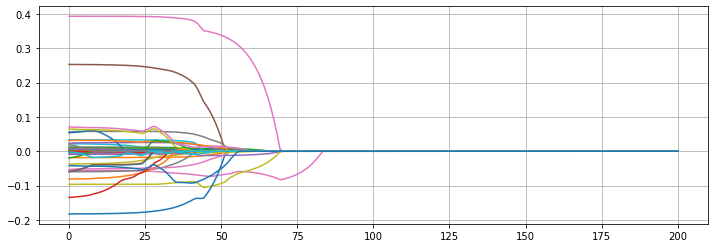

In [544]:
graph_reg(X_train, X_test, y_train, y_test, Lasso)

In [545]:
from sklearn.linear_model import Ridge

max_score 0.6265, alpha 26.421090173639946
использовал параметры 41 из 41
оставил параметры:
['lat', 'loc_x', 'loc_y', 'lon', 'period', 'playoffs', 'shot_distance', 'dayOfWeek', 'dayOfYear', 'month', 'year', 'quarter', 'secondsFromPeriodEnd', 'secondsFromPeriodStart', 'secondsFromGameStart', 'combined_shot_type_Bank Shot', 'combined_shot_type_Dunk', 'combined_shot_type_Hook Shot', 'combined_shot_type_Jump Shot', 'combined_shot_type_Layup', 'combined_shot_type_Tip Shot', 'shot_type_2PT Field Goal', 'shot_type_3PT Field Goal', 'shot_zone_area_Back Court(BC)', 'shot_zone_area_Center(C)', 'shot_zone_area_Left Side Center(LC)', 'shot_zone_area_Left Side(L)', 'shot_zone_area_Right Side Center(RC)', 'shot_zone_area_Right Side(R)', 'shot_zone_basic_Above the Break 3', 'shot_zone_basic_Backcourt', 'shot_zone_basic_In The Paint (Non-RA)', 'shot_zone_basic_Left Corner 3', 'shot_zone_basic_Mid-Range', 'shot_zone_basic_Restricted Area', 'shot_zone_basic_Right Corner 3', 'shot_zone_range_16-24 ft.',

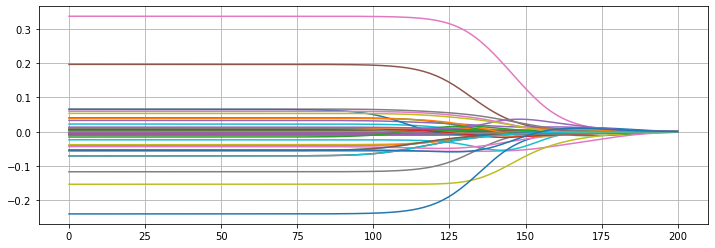

In [546]:
graph_reg(X_train, X_test, y_train, y_test, Ridge)

In [461]:
from sklearn.linear_model import LinearRegression

In [559]:
# посчитаем скор для разного количества фичей начиная с самых важных
feat_n,score = [], []
for i in range(len(col_imp)+1):
    col = col_imp[0:(1+i)]
    reg = LinearRegression().fit(X_train[col], y_train)
    sc = roc_auc_score(y_test, reg.predict(X_test[col]))
    score.append(sc)
    feat_n.append(i)

In [561]:
maxs = max(score)
maxi = score.index(max(score))

print(f'max_score {round(maxs,4)}')
print(f'использовал параметры {feat_n[maxi]} из {len(list(X_train.columns))}')

max_score 0.6274
использовал параметры 38 из 41


все три модели (линейная модель, Lasso, Ridge) показали одинаковый результат 0.63 по метрике ROC AUC. При этом модель Lasso использовала меньше всего переменных (29 из 41)